In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.18.5
pandas 1.0.5
sklearn 0.21.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
imdb = keras.datasets.imdb

 # num_words=10000的意思是训练集中我们指保留词频最高的前10000个单词。
 # 10000名之后的词汇都会被直接忽略，不出现在train_data和test_data中。
vocab_size = 10000
index_from = 3 

# 词的索引+3，因为数据集中词的索引从1开始，向右挪3个位置，
# 前面从0算起留出4个槽位，可以放0:【PAD】,1:【STAR】,2:【UNK】,3:【END】
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words = vocab_size, index_from = index_from)

In [4]:
# 加载词典 
word_index = imdb.get_word_index()
print(len(word_index))

for k,v in word_index.items():
    print(k,v)
    break
# print(word_index)
# 词对应的索引从1开始：the:1,and:2...

88584
fawn 34701


In [5]:
for k,v in word_index.items():
    if k=="fawn":
        print(v)

34701


In [6]:
# 把词的索引向右挪三个位置
word_index = {k:(v+3) for k, v in word_index.items()}

In [7]:
# 前面空出的槽位，添加4个标记
word_index['<PAD>'] = 0 # padding 填充位
word_index['<START>'] = 1 # 起始位
word_index['<UNK>'] = 2 # 空值
word_index['<END>'] = 3 # 结束标志

# 将词典中key、value置换
reverse_word_index = dict(
    [(value, key) for key, value in word_index.items()])


In [8]:

def decode_review(text_ids):
    """解析训练数据的内容"""
    return ' '.join(
        [reverse_word_index.get(word_id, "<UNK>") for word_id in text_ids])

In [9]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [10]:
print(reverse_word_index[14],reverse_word_index[22])

this film


In [11]:
for k,v in word_index.items():
    if v==0:
        print(k)

<PAD>


In [12]:
max_length = 500 # 句子高于500被截断，低于500被补全

# 进行数据补全
train_data = keras.preprocessing.sequence.pad_sequences(
    train_data, # list of list
    value = word_index['<PAD>'],# 用PAD的索引值0填充
    padding = 'post', # 不够max_length，post:往句子后填充, pre:向句子前方进行填充 
    maxlen = max_length)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data, # list of list
    value = word_index['<PAD>'],
    padding = 'post', # post, pre
    maxlen = max_length)

print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

In [13]:
# 定义模型
embedding_dim = 16 # 每个词embedding（转换）成长度为16的向量
batch_size = 128

single_rnn_model = keras.models.Sequential([
    # 1. define matrix: [vocab_size, embedding_dim]
    # 2. [1,2,3,4..], max_length * embedding_dim
    # 3. batch_size * max_length * embedding_dim
    # Embedding详解:https://www.jianshu.com/p/b2c33d7e56a5
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    #  return_sequences : 如果设置return_sequences=True，意思是返回每个展开的RNN cell的输出
    # return_sequences=False仅返回最后一个输出。 
    keras.layers.SimpleRNN(units=64,return_sequences=False),
    keras.layers.Dense(64,activation="relu"),
    keras.layers.Dense(1,activation="sigmoid"),
])

single_rnn_model.summary()
# binary_crossentropy:二分类交叉熵
single_rnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                5184      
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 169,409
Trainable params: 169,409
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = single_rnn_model.fit(train_data, train_labels,
                    epochs = 30,
                    batch_size = batch_size,
                    validation_split = 0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 44s 2ms/sample - loss: 0.6950 - accuracy: 0.5022 - val_loss: 0.6934 - val_accuracy: 0.5006
Epoch 2/30
20000/20000 [==============================] - 42s 2ms/sample - loss: 0.6956 - accuracy: 0.4999 - val_loss: 0.6930 - val_accuracy: 0.5054
Epoch 3/30
20000/20000 [==============================] - 41s 2ms/sample - loss: 0.6945 - accuracy: 0.5049 - val_loss: 0.6970 - val_accuracy: 0.4938
Epoch 4/30
20000/20000 [==============================] - 41s 2ms/sample - loss: 0.6962 - accuracy: 0.5117 - val_loss: 0.6960 - val_accuracy: 0.4956
Epoch 5/30
20000/20000 [==============================] - 41s 2ms/sample - loss: 0.6971 - accuracy: 0.5002 - val_loss: 0.6939 - val_accuracy: 0.4938
Epoch 6/30
20000/20000 [==============================] - 42s 2ms/sample - loss: 0.6945 - accuracy: 0.4979 - val_loss: 0.6935 - val_accuracy: 0.5062
Epoch 7/30
20000/20000 [==============================] -

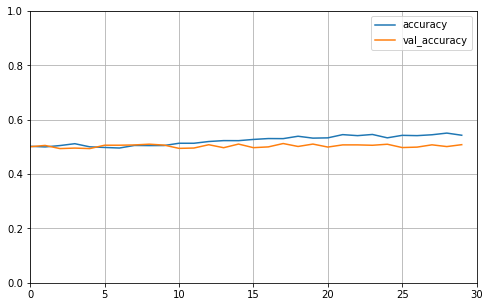

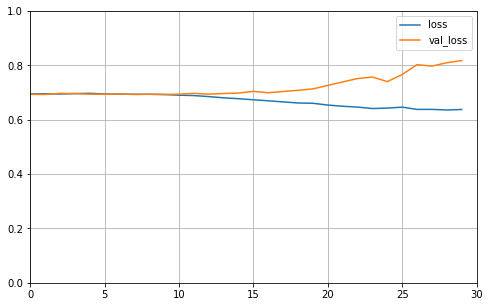

In [15]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', 30, 0, 1)
plot_learning_curves(history, 'loss', 30, 0, 1)

- 二分类问题，准确率太低，没什么意义
- 单层单向的rnn效果不理想

In [ ]:
single_rnn_model.evaluate(
    test_data, test_labels,
    batch_size = batch_size,)